<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Lgboost" data-toc-modified-id="Lgboost-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Lgboost</a></span></li><li><span><a href="#Random-forest" data-toc-modified-id="Random-forest-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Random forest</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import lightgbm as lgb
from scipy.stats import randint

import seaborn as sns
sns.set_theme()

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col='datetime')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
df = df.resample('1H').sum()

In [6]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [7]:
df.tail()

,num_orders
datetime,
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159
2018-08-31 22:00:00,223
2018-08-31 23:00:00,205


In [8]:
df.index.is_monotonic

True

В нашем распоряжении почасовая разбивка по заказам такси за 6 месяцев, 26т экземпляров, достаточно много

## Анализ

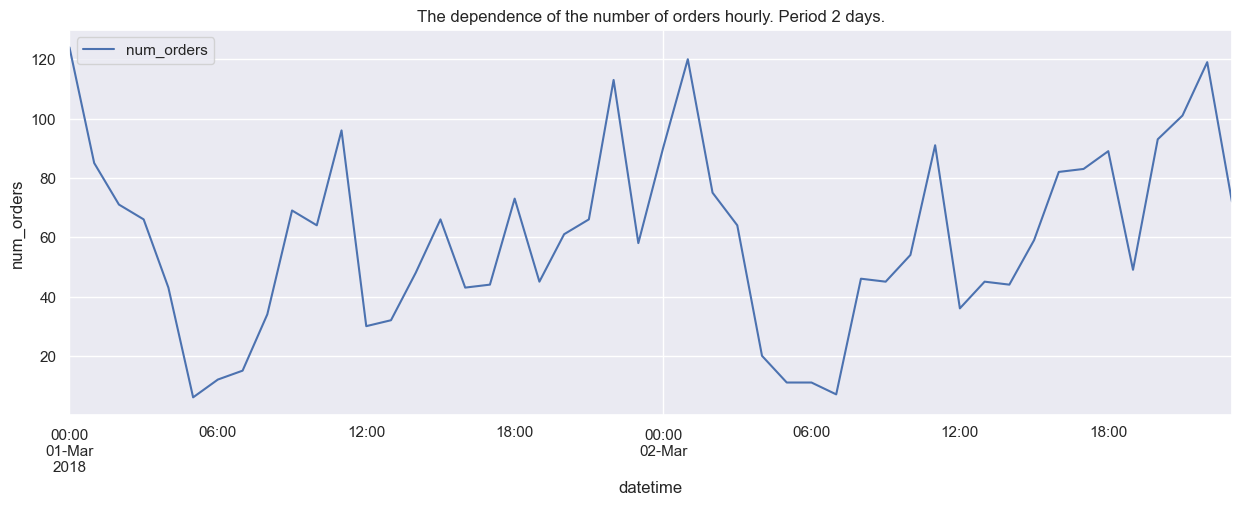

In [9]:
df['2018-03-01':'2018-03-02'].plot(figsize=(15,5))
plt.title('The dependence of the number of orders hourly. Period 2 days.')
plt.ylabel('num_orders');

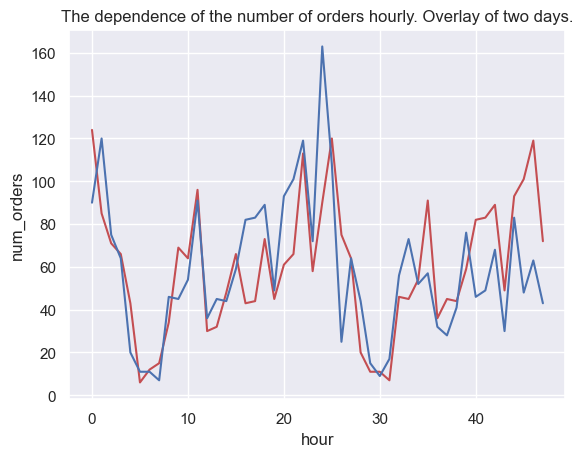

In [10]:
plt.plot(range(48), df['2018-03-01':'2018-03-02'].values, '-r')
plt.plot(range(48), df['2018-03-02':'2018-03-03'].values, '-b')
plt.title('The dependence of the number of orders hourly. Overlay of two days.')
plt.xlabel('hour')
plt.ylabel('num_orders')
plt.rcParams["figure.figsize"] = (10, 5);

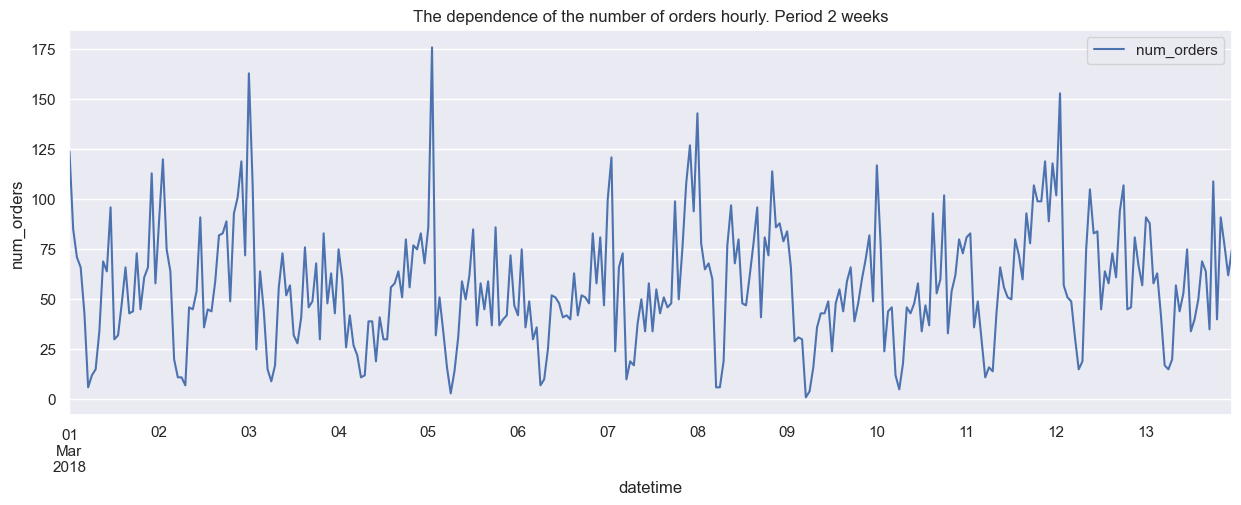

In [11]:
df['2018-03-01':'2018-03-13'].plot(figsize=(15,5))
plt.title('The dependence of the number of orders hourly. Period 2 weeks')
plt.ylabel('num_orders');

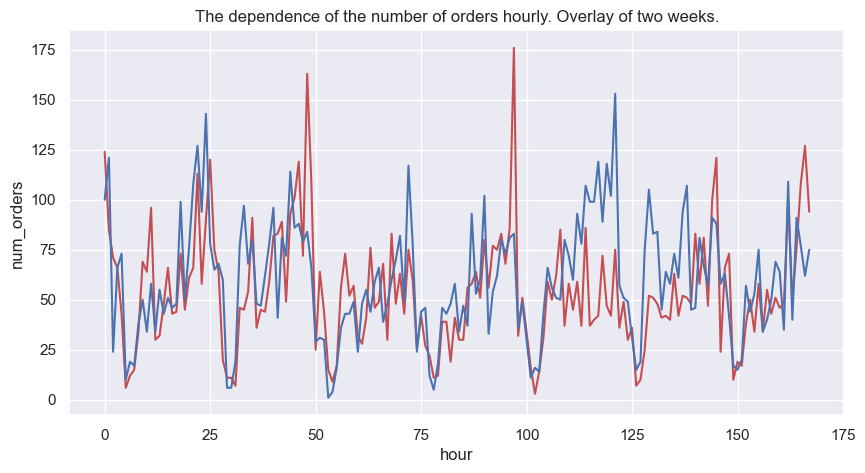

In [12]:
plt.plot(range(168), df['2018-03-01':'2018-03-07'].values, '-r')
plt.plot(range(168), df['2018-03-07':'2018-03-13'].values, '-b')
plt.title('The dependence of the number of orders hourly. Overlay of two weeks.')
plt.xlabel('hour')
plt.ylabel('num_orders')
plt.rcParams["figure.figsize"] = (10, 5);

На графиках видна определенная сезонность, как недельная, так и дневная. Наименьшее число заказов стабильно в 6ч, потом идет рост до 24ч

In [13]:
decomposed = sm.tsa.seasonal_decompose(df)

Text(0, 0.5, 'Residual')

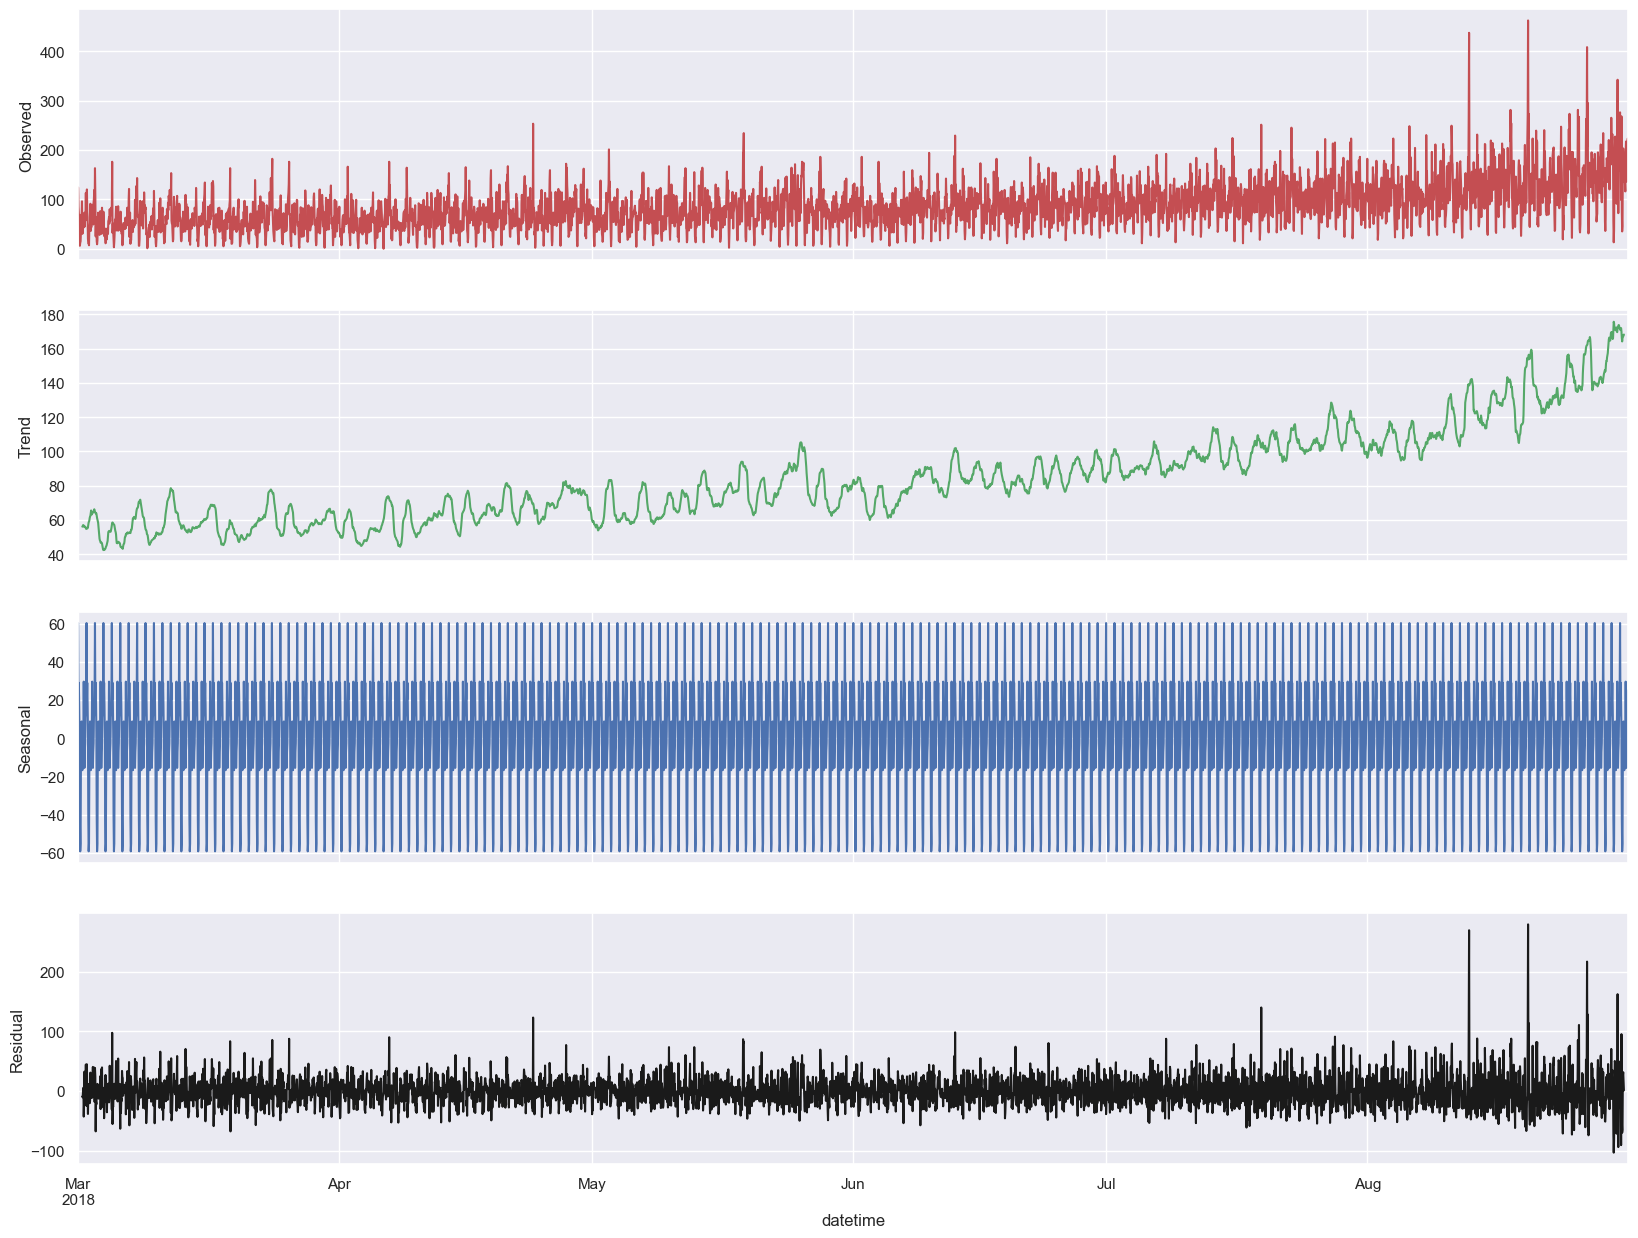

In [14]:
plt.rcParams['font.size'] = 14
plt.rcParams["figure.figsize"] = (20, 15)

res = sm.tsa.seasonal_decompose(df['num_orders'], model='additive')
fig, axes = plt.subplots(4, 1, sharex=True)

res.observed.plot(ax=axes[0], legend=False, color='r')
axes[0].set_ylabel('Observed')
res.trend.plot(ax=axes[1], legend=False, color='g')
axes[1].set_ylabel('Trend')
res.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
res.resid.plot(ax=axes[3], legend=False, color='k')
axes[3].set_ylabel('Residual')

Данные за последний месяц несколько более шумные данные - это приведет к ухудшению метрики качества

(-0.1, 1.1)

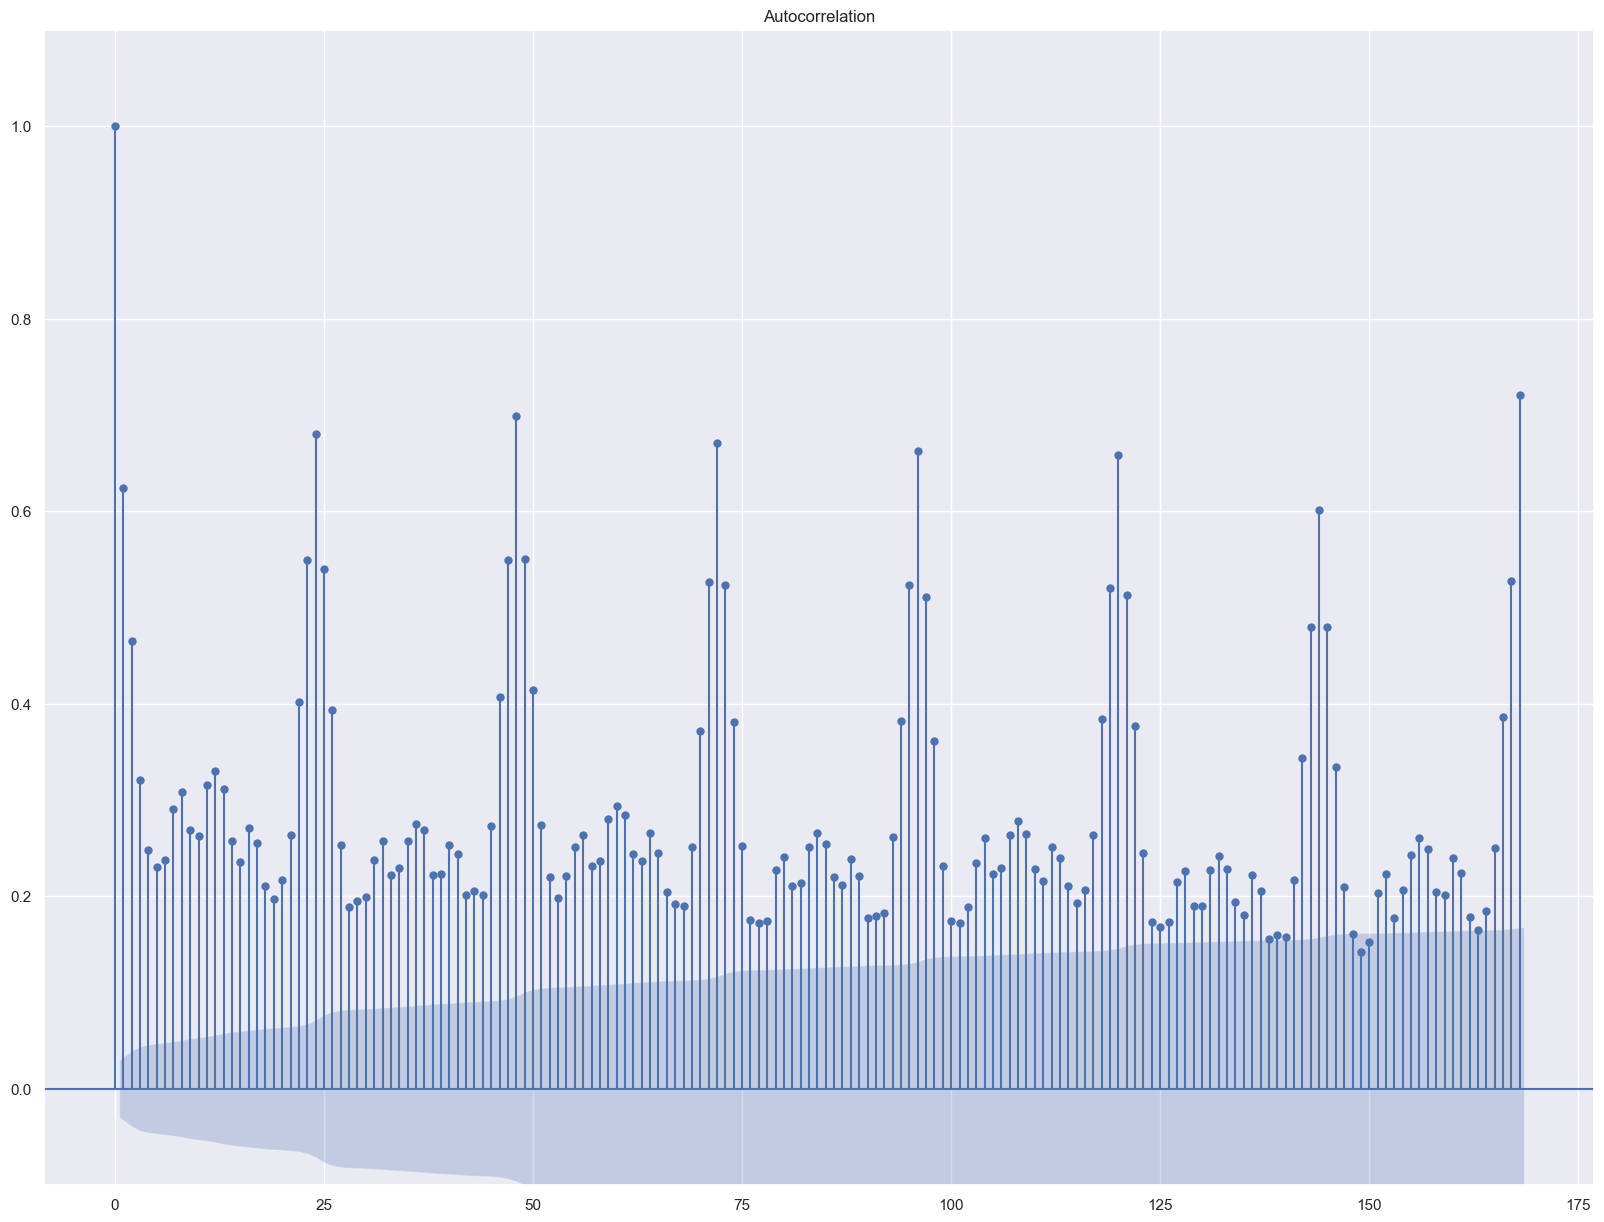

In [15]:
fig = plot_acf(df['num_orders'],lags= 24*7)
plt.rcParams["figure.figsize"] = (20, 5)
plt.ylim(-.1, 1.1)

(-0.2, 1.1)

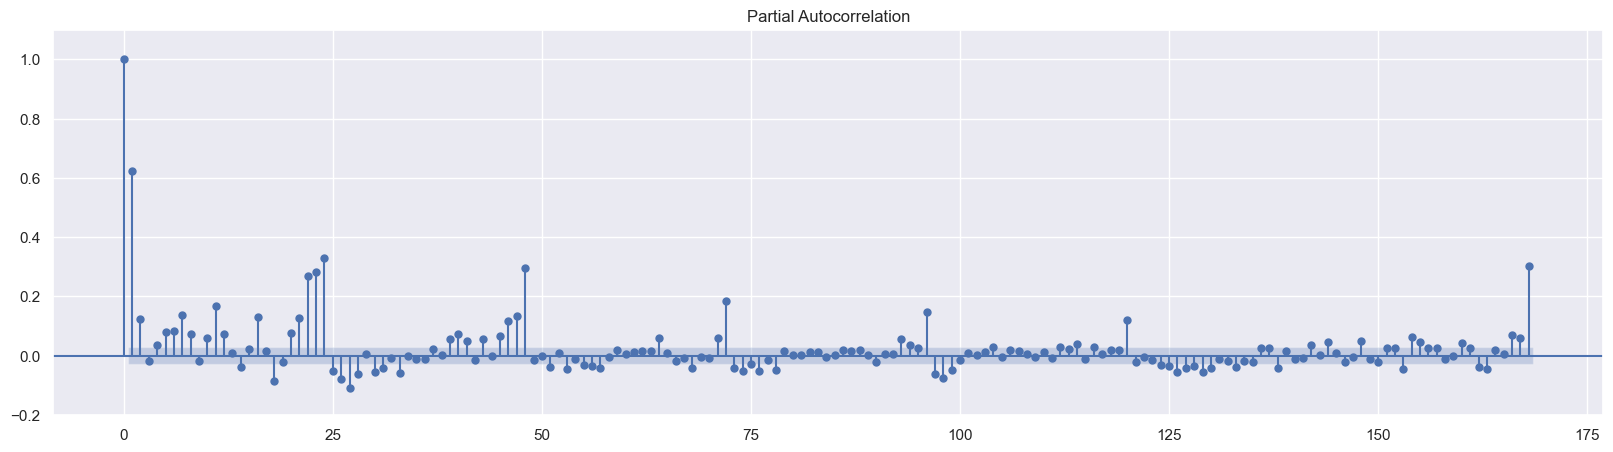

In [16]:
plot_pacf(df["num_orders"], lags=24*7)
plt.rcParams["figure.figsize"] = (20, 5)
plt.ylim(-.2, 1.1)

После подсчета автокорреляции получаем, что на значение в данный момент времени больше всего влияют последующий лаг, лаги днями раннее и недельный лаг. Добавим сразу все лаги за неделю и попробуем обучить модели на них

In [17]:
def make_features(df, max_lag, rolling_mean_size):
    df['day'] = df.index.day
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

In [18]:
make_features(df, 24*7, 24)

In [19]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

In [20]:
X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']

x_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

## Обучение

### Lgboost

In [21]:
grid={
    'max_depth':[6, 8, 10, 12],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators':[100, 200]
}

lgboost_model = GridSearchCV(
    lgb.LGBMModel(objective="regression"), 
    grid, cv=TimeSeriesSplit(n_splits=5), 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1
)

lgboost_model.fit(X_train, y_train);

In [22]:
print("NRMSE LGBооst:", lgboost_model.best_score_)

NRMSE LGBооst: -22.817970464545617


In [23]:
lgboost_model.best_params_

{'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 100}

### Random forest

In [24]:
grid={
    'max_depth':list(np.arange(3, 12, step=3)),
    'n_estimators':np.arange(10, 100, step=10),
    'max_features':np.arange(1, 7),
    'min_samples_leaf':np.arange(1, 4),
    'min_samples_split':np.arange(2, 10, step=2)
}

random_forest_model = RandomizedSearchCV(
    RandomForestRegressor(),
    grid, n_iter=10, cv=TimeSeriesSplit(n_splits=5), 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1, random_state=16
)

random_forest_model.fit(X_train, y_train);

In [25]:
print("NRMSE RF:", random_forest_model.best_score_)

NRMSE RF: -27.562628186581


In [26]:
random_forest_model.best_params_

{'n_estimators': 30,
 'min_samples_split': 2,
 'min_samples_leaf': 3,
 'max_features': 6,
 'max_depth': 6}

## Тестирование

Лучше всего показывает себя модель lgboost(`{'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 100}`), протестируем ее

In [27]:
y_pred = lgboost_model.predict(x_test)

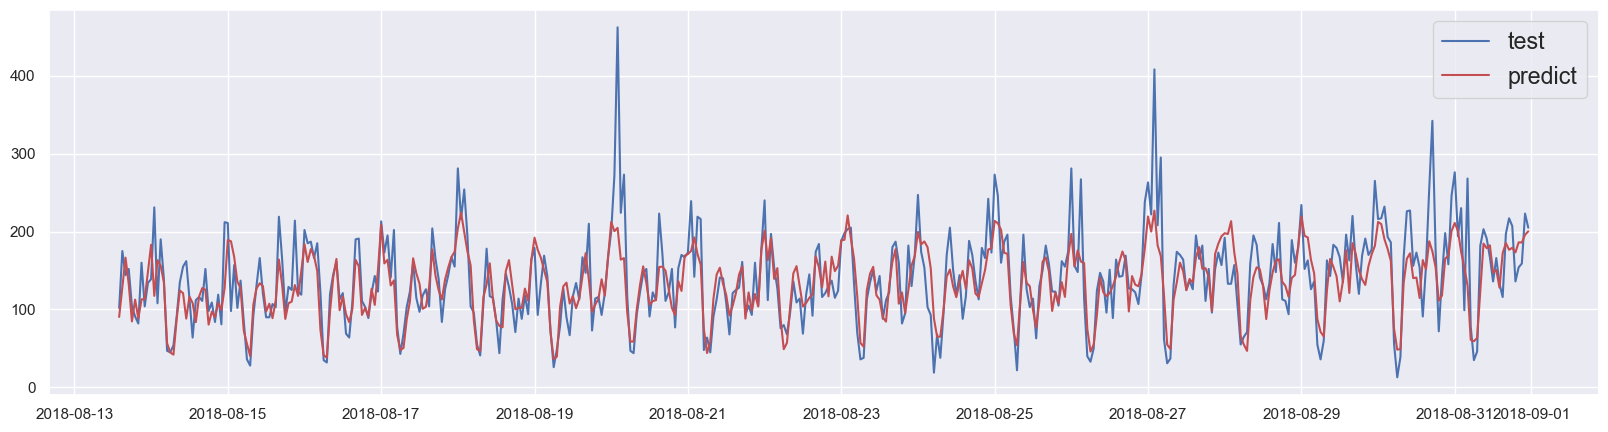

In [28]:
plt.plot(y_test.index, y_test, '-b', label='test')
plt.plot(y_test.index, y_pred, '-r', label='predict')
plt.legend(fontsize='large');

In [29]:
print("RMSE test:", mean_squared_error(y_pred, y_test)**0.5)

RMSE test: 36.78181062826721


In [30]:
print("RMSE 5d test:", mean_squared_error(y_pred[:5*24], y_test[:5*24])**0.5)

RMSE 5d test: 30.39433485954269


Видно влияние этих выбросов, из-за этого немного поплыла метрика. Если бы этих выбросов не было, то получилось бы значение на всем тесте как на первой пятидневке</font>

Модель, как и ожидалось, лучше всего предсказывает ближайшее будущее(5д), однако и на 18 дней rmse приемлемо. Проверим модель на адекватность

In [31]:
pred_previous = y_test.shift(fill_value=y_train.iloc[-1])
print("RMSE dummy:", mean_squared_error(y_test, pred_previous)**0.5)

RMSE dummy: 58.856486242815066


Как видно, модель и на короткой и на длинной дистанции дает адекватный результат

## Вывод

1. Выявили минимальное необходимое число лагов (24*7) для построения модели. Наполнили выборки лагами, скользящим средним за 7 дней, временем и датой.
2. Обучили модели случайного леса и градиентного бустинга предсказывать почасовое число заказов такси у аэропорта. Тестировали модель LGBoost как наилучшую. На тесте RMSE 44.2(18д), 32.3(5д) - модель показывает себя лучше в предсказаниях в недалеком будущем.